# Dignity in ECHR - Document Clustering and Topic modelling approach

Bianca Chiusano

A belief in human dignity lies at the root of the modern legal commitment to human rights. Appeals to human dignity are to be found in many of the founding documents of this legal regime. The Universal Declaration of Human Rights states in the preamble.

> Whereas the peoples of the United Nations have in the Charter reaffirmed their faith in fundamental human rights, in the dignity and worth of the human person and in the equal rights of men and women and have determined to promote social progress and better standards of life in larger freedom,

The Declaration of Bogotá states that predates the :

>The American peoples have acknowledged the dignity of the individual, and their national constitutions recognize that juridical and political institutions, which regulate life in human society, have as their principal aim the protection of the essential rights of man and the creation of circumstances that will permit him to achieve spiritual and material progress and attain happiness;

The German Basic Law of 1948, in its very first article states categorically:

> Human dignity shall be inviolable. To respect and protect it shall be the duty of all state authority

The African Convention on Human and People's Rights states:

> Considering the Charter of the Organisation of African Unity, which stipulates that “freedom, equality, justice and dignity are essential objectives for the achievement of the legitimate aspirations of the African peoples”;

However dignity is a divisive concept. In the 90s it attracted high-level polemic. Philosopher Anne Ruth Mackor and Psychologist Steven Pinker both rejected the concept as vague, conservative and "stupid". In their view, the concept of dignity .

Similar polemics arose later, now with

The claims of Mackor and Pinker received replies from believers in dignity, including prominently, human rights lawyers.

TBC

## Imports

In [90]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import pandas as pd
import nltk
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
from wordcloud import WordCloud
import os

In [92]:
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Methods used for pre-processing and wordclouds

In [93]:
'''
 "Sklearn provides facilities to extract numerical features from a text document
 by tokenizing, counting and normalising. CountVectorizer performs the task of tokenizing
 and counting, while TfidfTransformer normalizes the data. TfidfVectorizer, on the other hand,
 performs all three operations, thereby streamlining the process of natural language processing"

 from: https://medium.com/geekculture/how-sklearns-countvectorizer-and-tfidftransformer-compares-with-tfidfvectorizer-a42a2d6d15a2
'''
def tf_idf_vectorizer(facts_df):
    # Vectorise
    vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
    # Matrix of vectors that will be used to train KMeans
    matrix = vectorizer.fit_transform(facts_df['Facts'])

    return vectorizer, matrix


# This function is to calculate inertia when SVD is applied, inertia_list used for plotting
def calc_inertia_svd(X_svd, end, step):
    inertia_list = []
    for k in range(1, end, step):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_svd)
        inertia_list.append(kmeans.inertia_)

    return inertia_list

# This function is to calculate inertia when SVD is applied, inertia_list used for plotting
def calc_inertia_pca(X_pca, end, step):
    inertia_list = []
    for k in range(1, end, step):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_pca)
        inertia_list.append(kmeans.inertia_)

    return inertia_list


def word_cloud_generator(X, in_X_tfidf, k, in_word_positions):
    # Clustering
    in_model = KMeans(n_clusters=k, random_state=42)
    in_y_pred = in_model.fit_predict(X)
    in_cluster_ids = set(in_y_pred)

    # Number of words with highest tfidf score to display
    top_count = 100

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {in_cluster_id}")
        #plt.show()
        if not os.path.exists('wordclouds'):
            os.makedirs('wordclouds')
        plt.savefig(f"wordclouds/cloud {in_cluster_id}.png")

    return in_cluster_ids, in_model

def remove_lang_words(facts_words, english_words):
    # Filtering out non-english words and three-letter words
    filtered = [word for word in facts_words if word in english_words and len(word) > 3]
    return filtered

## Importing the data by mounting google drive

In [94]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [95]:
all_processed_facts = pd.read_csv('/content/drive/MyDrive/MacBook Air/dignity project/Data/facts_processed.csv')

In [96]:
dignity_cases = pd.read_csv('/content/drive/MyDrive/MacBook Air/dignity project/Data/dignity_cases.csv')

## Preprocessing the facts once more to make sure that only english words are included

Some more pre-processing (Removing non-english words and words that have less than three letters)

In [97]:
new_facts = pd.DataFrame(columns=['Facts'])
english_words = set(nltk.corpus.words.words())

In [98]:
for fact in all_processed_facts['Facts']:
    fact_words = fact.split()
    facts_words_filtered = remove_lang_words(fact_words, english_words)
    new_fact = ' '.join(facts_words_filtered)
    new_row = pd.DataFrame({'Facts': [new_fact]})
    new_facts = pd.concat([new_facts, new_row], ignore_index=True)


# K-Means Clustering using PCA as dimensionality reduction

In [99]:
vectorizer, tfidf_matrix = tf_idf_vectorizer(new_facts)
pca = PCA(2)
X_pca = pca.fit_transform(tfidf_matrix.toarray())
print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.2f}")

Total variance explained: 0.06


### Inertia

The measure of inertia can be used in order to help determine the number of clusters to be used. Here we explore the inertia scores for 1 to 20 clusters. Inertia is defined as the sum of squared distances obtained by a distance function *dist* from each data point *i* to its hypothesized centroid *c*, for each hypothesized cluster *k*.

$$  \sum_{k=1}^{k=n} \sum_{i=1}^{i=n} (dist(c,i))^2  $$

While a lower inertia score is preferred, inertia will naturally increase with the number of clusters, and will be minimized when every data point i is assigned to its own cluster. So in practice what is needed is a compromise between the inertia score and the number of clusters. This is commonly found visually using the elbow method. This looks for the places where the slope of the curve of inertia over the number of clusters deaccelerates. Here we find an elbow at around 5 clusters, and another around 11. However qualitatively we seem to get the best interpretable results at 8 clusters.

Text(0.5, 1.0, 'Calculating Inertia for K Clusters')

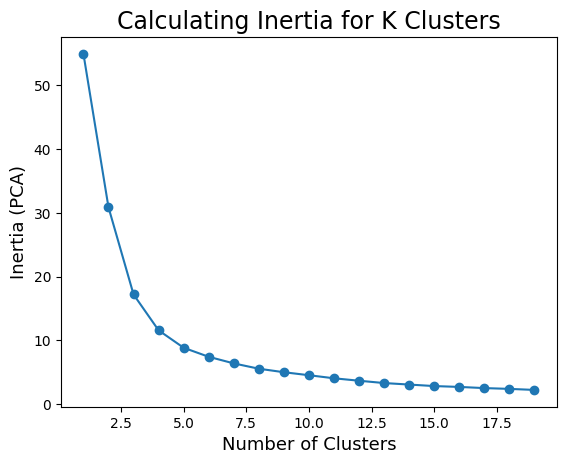

In [100]:
# Calculating the Inertia
warnings.filterwarnings('ignore')
inertia_list = calc_inertia_pca(X_pca, 20, 1)
plt.plot(range(1, 20, 1), inertia_list)
plt.scatter(range(1, 20, 1), inertia_list)
#plt.scatter(4, inertia_list[4], marker="X", s=300, c="r")

plt.xlabel("Number of Clusters", size=13)
plt.ylabel("Inertia (PCA)", size=13)
plt.title("Calculating Inertia for K Clusters", size=17)

In [101]:
# Wordclouds using PCA
word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
cluster_ids, kmeans = word_cloud_generator(X_pca, tfidf_matrix, 8, word_positions)

Output hidden; open in https://colab.research.google.com to view.

# K_Means Clustering with PCA (dimensionality Reduction)

In [102]:
def kmeans_pca(k, n_components):
  pca = PCA(n_components)
  X_pca = pca.fit_transform(tfidf_matrix.toarray())

  # Applying Kmeans
  kmeans_pca = KMeans(8)
  label_trial = kmeans_pca.fit_predict(X_pca)

  clusters = kmeans_pca.labels_
  unique_labels = np.unique(label_trial)

  # getting the top keywords
  top_words = pd.DataFrame(tfidf_matrix.todense()).groupby(clusters).mean()
  terms = vectorizer.get_feature_names_out()
  for i, r in top_words.iterrows():
    print('\nCluster {}'.format(i))
    print(','.join([terms[t] for t in np.argsort(r)[-10:]]))

  #plot
  centroids_trial = kmeans_pca.cluster_centers_
  for i in unique_labels:
    plt.scatter(X_pca[label_trial == i][:,0], X_pca[label_trial == i][:,1], label = i)
  plt.scatter(centroids_trial[:,0] , centroids_trial[:,1] , s = 80, color = 'k')
  plt.legend()
  plt.show()

  return label_trial, centroids_trial, unique_labels, clusters, X_pca


Cluster 0
arrest,whether,taken,report,detention,injury,treatment,medical,investigation,officer

Cluster 1
margin,opinion,political,constitution,interference,protection,member,chamber,majority,constitutional

Cluster 2
name,degrading,rate,affront,disclose,confinement,table,courtroom,metal,cage

Cluster 3
life,international,whether,member,parent,would,measure,family,protection,child

Cluster 4
criticism,statement,press,debate,publication,interference,newspaper,journalist,defamation,reputation

Cluster 5
code,provision,cost,rate,protection,damage,constitutional,would,whether,interference

Cluster 6
facility,inhuman,rate,degrading,condition,medical,treatment,prison,cell,detention

Cluster 7
hospital,inmate,facility,doctor,treatment,prisoner,cell,medical,prison,detention


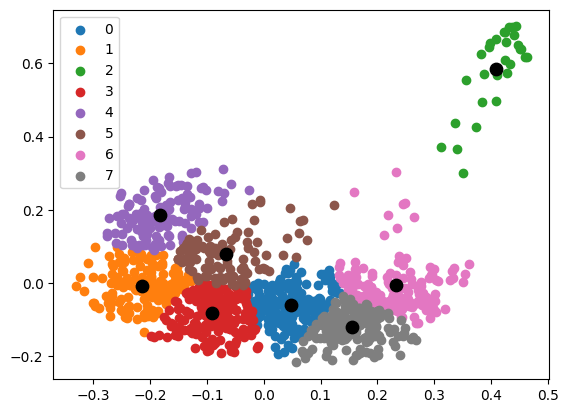

In [103]:
label_trial, centroids_trial, unique_labels, clusters, X_pca = kmeans_pca(4, 2)

### Finding the Centroids (Case) for each cluster

In [104]:
overall_df = pd.DataFrame(columns = ['Case', 'Facts', 'PCA1', 'PCA2', 'Cluster', 'Center1', 'Center2'])
overall_df['Case'] = dignity_cases['Case']
overall_df['Facts'] = all_processed_facts['Facts']
overall_df['PCA1'] = X_pca[:,0]
overall_df['PCA2'] = X_pca[:,1]
overall_df['Cluster'] = label_trial

array_center_1 = []
array_center_2 = []
for lab in overall_df['Cluster']:
  array_center_1.append(centroids_trial[lab,0])
  array_center_2.append(centroids_trial[lab,1])

overall_df['Center1'] = array_center_1
overall_df['Center2'] = array_center_2

In [105]:
distances = []
for i in range(len(overall_df['Case'])):
  a = np.array([overall_df['Center1'].loc[[i]], overall_df['Center2'].loc[[i]]])
  b = np.array([overall_df['PCA1'].loc[[i]], overall_df['PCA2'].loc[[i]]])
  dist = np.linalg.norm(a-b)
  distances.append(dist)

overall_df['Dist'] = distances
overall_df.head(10)

,Case,Facts,PCA1,PCA2,Cluster,Center1,Center2,Dist
0,001-168374.txt,born life vilnius around motorcycle collided c...,0.012122,-0.037384,0,0.048603,-0.060830,0.043366
1,001-128036.txt,introduction lived worked farmer village kuşko...,-0.017025,-0.048014,0,0.048603,-0.060830,0.066867
2,001-156265.txt,detail concerning found annex background oliar...,-0.250659,-0.042900,1,-0.215038,-0.006808,0.050710
3,001-126972.txt,born life râmnicu vâlcea pretrial detention ag...,0.058007,0.002193,0,0.048603,-0.060830,0.063721
4,001-181273.txt,born life louvencourt hired french national ra...,-0.092904,0.037815,5,-0.065887,0.078115,0.048519
5,001-145225.txt,born currently detained iaşi prison detained p...,0.273406,-0.029222,6,0.232909,-0.006109,0.046629
6,001-127107.txt,born life shropshire severely disabled result ...,-0.049482,-0.072820,3,-0.091509,-0.080794,0.042776
7,001-195992.txt,born life warsaw submitted party summarised ar...,0.159606,-0.085814,7,0.156011,-0.119528,0.033905
8,001-221519.txt,information relevant set appended table compla...,0.443998,0.700278,2,0.408063,0.583628,0.122060
9,001-145741.txt,born life dubrovnik incident around dubrovnik ...,-0.000901,-0.060949,0,0.048603,-0.060830,0.049504


In [106]:
# Checking how many cases are in each cluster
overall_df['Cluster'].value_counts()

0    203
3    194
7    167
1    143
6    137
4    132
5    108
2     29
Name: Cluster, dtype: int64

In [107]:
closest_array = []
closest = 100
for lab in range(8):
  for i in range(len(overall_df['Case'])):
    if overall_df.loc[i, 'Cluster'] == lab:
      dist = overall_df.loc[i, 'Dist']
      if dist < closest:
        closest = dist
  closest_array.append(closest)
  closest = 100

represent = []

for i in range(len(overall_df['Case'])):
  if overall_df.loc[i, 'Dist'] in closest_array:
    represent.append(True)
  else:
    represent.append(False)

overall_df['Represent'] = represent

overall_df.head(10)

,Case,Facts,PCA1,PCA2,Cluster,Center1,Center2,Dist,Represent
0,001-168374.txt,born life vilnius around motorcycle collided c...,0.012122,-0.037384,0,0.048603,-0.060830,0.043366,False
1,001-128036.txt,introduction lived worked farmer village kuşko...,-0.017025,-0.048014,0,0.048603,-0.060830,0.066867,False
2,001-156265.txt,detail concerning found annex background oliar...,-0.250659,-0.042900,1,-0.215038,-0.006808,0.050710,False
3,001-126972.txt,born life râmnicu vâlcea pretrial detention ag...,0.058007,0.002193,0,0.048603,-0.060830,0.063721,False
4,001-181273.txt,born life louvencourt hired french national ra...,-0.092904,0.037815,5,-0.065887,0.078115,0.048519,False
5,001-145225.txt,born currently detained iaşi prison detained p...,0.273406,-0.029222,6,0.232909,-0.006109,0.046629,False
6,001-127107.txt,born life shropshire severely disabled result ...,-0.049482,-0.072820,3,-0.091509,-0.080794,0.042776,False
7,001-195992.txt,born life warsaw submitted party summarised ar...,0.159606,-0.085814,7,0.156011,-0.119528,0.033905,False
8,001-221519.txt,information relevant set appended table compla...,0.443998,0.700278,2,0.408063,0.583628,0.122060,False
9,001-145741.txt,born life dubrovnik incident around dubrovnik ...,-0.000901,-0.060949,0,0.048603,-0.060830,0.049504,False


In [108]:
overall_sorted = overall_df.sort_values(by='Represent')
filtered_df = overall_sorted[overall_sorted["Represent"] == True]
centroids_sorted = filtered_df.sort_values(by='Cluster')

Final Cluster Centers (8 clusters):

- GUÐMUNDUR ANDRI ÁSTRÁÐSSON v. ICELAND (001-191701.txt)
- BARSUKOV v. RUSSIA (001-174063.txt)
- PRANJIĆ-M-LUKIĆ v. BOSNIA AND HERZEGOVINA (001-202620.txt)
- KUIMOV v. RUSSIA (001-219715.txt)
- M.L. v. NORWAY (001-207017.txt)
- YANEZ PINON AND OTHERS v. MALTA (001-179568.txt)
- PETKEVIČIŪTĖ v. LITHUANIA (001-181211.txt)
- KOSTYUCHENKO v. RUSSIA	(001-194309.txt)

In [109]:
centroids_sorted

,Case,Facts,PCA1,PCA2,Cluster,Center1,Center2,Dist,Represent
731,001-202620.txt,life karlsruhe granted leave represent initial...,0.052462,-0.060275,0,0.048603,-0.060830,0.003898,True
192,001-191701.txt,establishment new appointment new within icela...,-0.207156,0.002046,1,-0.215038,-0.006808,0.011854,True
904,001-219715.txt,information relevant set appended table compla...,0.411191,0.567456,2,0.408063,0.583628,0.016471,True
809,001-207017.txt,life represented arnesen practising bergen rep...,-0.095967,-0.079475,3,-0.091509,-0.080794,0.004649,True
334,001-181211.txt,born life vilnius father book father wellknown...,-0.184121,0.188213,4,-0.182148,0.185095,0.003690,True
188,001-194309.txt,born life samara appointed indefinite period c...,-0.074415,0.082406,5,-0.065887,0.078115,0.009546,True
477,001-174063.txt,born tambov region arrest lived petersburg arr...,0.234602,-0.004906,6,0.232909,-0.006109,0.002077,True
277,001-179568.txt,born respectively time lodged detained corradi...,0.156273,-0.123425,7,0.156011,-0.119528,0.003906,True


In [110]:
centroids_sorted.to_csv('/content/drive/MyDrive/MacBook Air/dignity project/Experiments/centroids_sorted.csv')

In [111]:
silhouette = silhouette_score(X_pca, label_trial)

In [112]:
print(silhouette)

0.3612147566376708


# K-Means Clustering using TruncatedSVD as dimensionality reduction

In [113]:
# Dimensionality reduction applied by means of Singular value decomposition
vectorizer, tfidf_matrix = tf_idf_vectorizer(new_facts)
svd = TruncatedSVD(n_components= 2, random_state=42)
X_svd = svd.fit_transform(tfidf_matrix)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.04


Text(0.5, 1.0, 'Calculating Inertia for K Clusters')

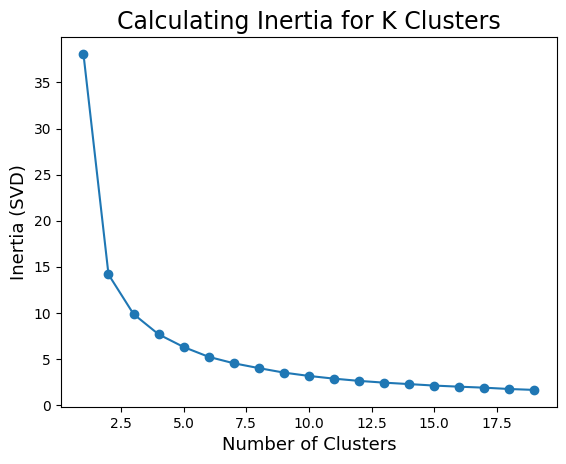

In [114]:
# Calculating the Inertia
warnings.filterwarnings('ignore')
inertia_list = calc_inertia_svd(X_svd, 20, 1)
plt.plot(range(1, 20, 1), inertia_list)
plt.scatter(range(1, 20, 1), inertia_list)
#plt.scatter(8, inertia_list[8], marker="X", s=300, c="r")

plt.xlabel("Number of Clusters", size=13)
plt.ylabel("Inertia (SVD)", size=13)
plt.title("Calculating Inertia for K Clusters", size=17)

In [115]:
# Wordclouds using SVD
word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
cluster_ids, kmeans = word_cloud_generator(X_svd, tfidf_matrix, 8, word_positions)

Output hidden; open in https://colab.research.google.com to view.

In [116]:
def kmeans_svd(k, n_components):
  svd = TruncatedSVD(n_components, random_state = 42)
  X_svd = svd.fit_transform(tfidf_matrix)

  k_means_svd = KMeans(n_clusters=8, random_state=42)
  in_y_pred = k_means_svd.fit_predict(X_svd)

  clusters_svd = k_means_svd.labels_
  unique_labels_svd = np.unique(in_y_pred)

  # getting the top keywords
  top_words = pd.DataFrame(tfidf_matrix.todense()).groupby(clusters_svd).mean()
  terms = vectorizer.get_feature_names_out()
  for i, r in top_words.iterrows():
    print('\nCluster {}'.format(i))
    print(','.join([terms[t] for t in np.argsort(r)[-10:]]))

  #plot
  centroids_svd = k_means_svd.cluster_centers_
  for i in unique_labels_svd:
    plt.scatter(X_svd[in_y_pred == i][:,0], X_svd[in_y_pred == i][:,1], label = i)
  plt.scatter(centroids_svd[:,0] , centroids_svd[:,1] , s = 80, color = 'k')
  plt.legend()
  plt.show()

  return in_y_pred, centroids_svd, unique_labels_svd, clusters_svd, X_svd


Cluster 0
treatment,rate,degrading,cell,confinement,table,detention,courtroom,metal,cage

Cluster 1
procedure,protection,report,measure,first,damage,taken,investigation,whether,would

Cluster 2
publication,democratic,society,whether,newspaper,protection,statement,defamation,interference,reputation

Cluster 3
arrest,prisoner,facility,condition,inmate,treatment,medical,cell,prison,detention

Cluster 4
private,obligation,individual,whether,family,member,would,measure,protection,child

Cluster 5
prison,rate,hospital,doctor,treatment,detention,investigation,medical,injury,officer

Cluster 6
private,member,legitimate,opinion,political,constitutional,protection,debate,reputation,interference

Cluster 7
report,prisoner,injury,cell,investigation,treatment,officer,prison,medical,detention


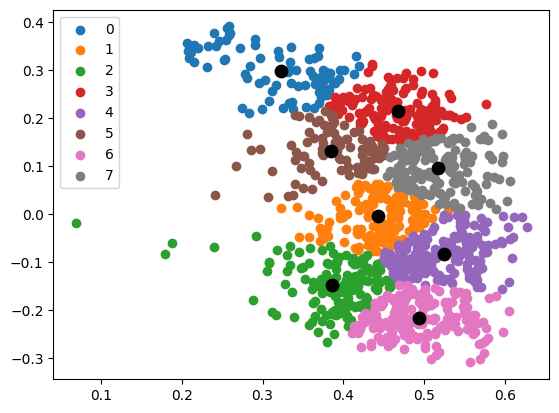

In [117]:
in_y_pred, centroids_svd, unique_labels_svd, clusters_svd, X_svd = kmeans_svd(4, 2)

In [118]:
silhouette = silhouette_score(X_svd, in_y_pred)
print(silhouette)

0.3530657449188951


In [119]:
X_svd.shape

(1113, 2)

# Clustering Evaluation metrics (Tests)

There are some tests: Complexity, homogenety, rand-index, v_measure_score etc. that need the actual labelling to perform the test, and we don't have that.

So we will be using the sillouette score.

In [120]:
evaluation_df = pd.DataFrame(columns = ['k', 'n_components', 'variance_pca', 'silhouette_pca', 'variance_svd', 'silhouette_svd'])

k_list = []
components_list = []
variance_pca_list = []
variance_svd_list = []
silhouette_pca_list = []
silhouette_svd_list = []

max_sil_pca = max_sil_svd = -2

for k in range(4, 9):
  for components in range(2, 503, 125):

    k_list.append(k)
    components_list.append(components)

    # PCA
    pca = PCA(components)
    X_pca = pca.fit_transform(tfidf_matrix.toarray())
    kmeans_pca = KMeans(k)
    label_trial = kmeans_pca.fit_predict(X_pca)
    silhouette_pca_avg = silhouette_score(X_pca, label_trial)

    if max_sil_pca < silhouette_pca_avg:
      max_sil_pca = silhouette_pca_avg

    variance_pca_list.append(np.sum(pca.explained_variance_ratio_))
    silhouette_pca_list.append(silhouette_pca_avg)


    # SVD
    svd = TruncatedSVD(components)
    X_svd = svd.fit_transform(tfidf_matrix)
    k_means_svd = KMeans(k)
    in_y_pred = k_means_svd.fit_predict(X_svd)

    silhouette_svd_avg = silhouette_score(X_svd, in_y_pred)

    if max_sil_svd < silhouette_svd_avg:
      max_sil_svd = silhouette_svd_avg

    variance_svd_list.append(np.sum(svd.explained_variance_ratio_))
    silhouette_svd_list.append(silhouette_svd_avg)


evaluation_df['k'] = k_list
evaluation_df['n_components'] = components_list
evaluation_df['variance_pca'] = variance_pca_list
evaluation_df['silhouette_pca'] = silhouette_pca_list
evaluation_df['variance_svd'] = variance_svd_list
evaluation_df['silhouette_svd'] = silhouette_svd_list


print(max_sil_pca)
print(max_sil_svd)
evaluation_df.head()

0.4391847559067082
0.36284447232799294


,k,n_components,variance_pca,silhouette_pca,variance_svd,silhouette_svd
0,4,2,0.062405,0.439185,0.043289,0.362844
1,4,127,0.397750,0.077324,0.398678,0.077150
2,4,252,0.542528,0.061060,0.544227,0.060794
3,4,377,0.655056,0.052392,0.657108,0.052872
4,4,502,0.747072,0.047523,0.748811,0.042492


In [121]:
# Find the row with the highest silhouette_pca value
best_pca_row = evaluation_df.loc[evaluation_df['silhouette_pca'].idxmax()]

# Find the row with the best silhouette_svd value
best_svd_row = evaluation_df.loc[evaluation_df['silhouette_svd'].idxmax()]

print("Row with highest silhouette_pca value:")
print(best_pca_row)

print("\nRow with best silhouette_svd value:")
print(best_svd_row)

Row with highest silhouette_pca value:
k                 4.000000
n_components      2.000000
variance_pca      0.062405
silhouette_pca    0.439185
variance_svd      0.043289
silhouette_svd    0.362844
Name: 0, dtype: float64

Row with best silhouette_svd value:
k                 4.000000
n_components      2.000000
variance_pca      0.062405
silhouette_pca    0.439185
variance_svd      0.043289
silhouette_svd    0.362844
Name: 0, dtype: float64
